# Imports and set-up

In [2]:
%pylab notebook
import numpy as np
import pandas as pd
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [4]:
np.set_printoptions(
    edgeitems=30, linewidth=100000)

# Load and clean data

## Load data sets

In [5]:
customers = pd.read_csv("./data_updated/customers.csv")
districts = pd.read_csv("./data_updated/districts.csv")
transacts = pd.read_csv("./data_updated/transactions.csv")
transacts.head()

,TRANS_ID,ACCOUNT_ID,DATE,AMOUNT,BALANCE,TYPE,OPERATION
0,695247,2378.0,1011993,700.0,700.0,CREDIT,CREDIT_IN_CASH
1,171812,576.0,1011993,900.0,900.0,CREDIT,CREDIT_IN_CASH
2,207264,704.0,1011993,1000.0,1000.0,CREDIT,CREDIT_IN_CASH
3,1117247,3818.0,1011993,600.0,600.0,CREDIT,CREDIT_IN_CASH
4,579373,1972.0,2011993,400.0,400.0,CREDIT,CREDIT_IN_CASH


## Customers 


### Check for missing values

The easy way to check for missing numerical values is to use the `dropna()` method and see if the dataframe changes size. There might of course be defective values in string columns, we will look at that later.


In [7]:
print(customers.shape)
print(customers.dropna().shape)

(4450, 8)
(4400, 8)


It did change size, so now we need to decide whether to get rid of these values or not, or maybe do it later. Some features are not crucial for the integrity of a data set, some are.

In [8]:
nan_cols = set(where(customers.isnull())[1])
[customers.columns[j] for j in nan_cols]

['LOAN']

All missing values are in the =LOAN= column, which is the target variable of this entire dataset. So, I decide to remove all rows with missing values in this dataset.


In [10]:
customers_nonan = customers.dropna()

### Check data types

We want to check whether the data columns have sensible data types.

In [11]:
customers_nonan.dtypes

CLIENT_ID        int64
ACCOUNT_ID       int64
GENDER          object
BIRTH_DT         int64
ACTIVE           int64
LOAN           float64
DISTRICT_ID      int64
SET_SPLIT       object
dtype: object

`LOAN` looks like it should be a categorical value, and thus should be an integer. For the sake of later modeling, we may want to convert the categorical `GENDER` variable into a 0/1 encoding later, but for the sake of exploration, it is fine to have it as labels.

I now check whether `LOAN` is truly categorical, and whether the other categorical values contain problematic values. In the same turn, I will check whether there is a 1:1 correspondence between `CLIENT_ID` and `ACCOUNT_ID`, in which case one of them can be dropped.

`BIRTH_DT` has a non-standard format but it does sort correctly so I will keep it as is for now. With more time, I would probably turn it into a `DateTime` object.


In [12]:
print(customers_nonan.LOAN.value_counts())
print(customers_nonan.ACTIVE.value_counts())
print(customers_nonan.GENDER.value_counts())
print(customers_nonan.groupby("ACCOUNT_ID").count()["CLIENT_ID"].unique())


0.0    3740
1.0     660
Name: LOAN, dtype: int64
1    4400
Name: ACTIVE, dtype: int64
M    2244
F    2156
Name: GENDER, dtype: int64
[1]


As suspected, =LOAN= is truly categorical and should thus be an integer. `ACTIVE` contains only one value and can be dropped. There is one and only one account per customer, so the `CLIENT_ID` column can also be dropped.

In [13]:
customers_nonan.LOAN = customers_nonan["LOAN"].astype(int)
customers_clean = customers_nonan.drop(["ACTIVE", "CLIENT_ID"], axis=1)
customers_clean.dtypes

/home/trive/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


ACCOUNT_ID      int64
GENDER         object
BIRTH_DT        int64
LOAN            int64
DISTRICT_ID     int64
SET_SPLIT      object
dtype: object

### Quicklook: Correlation coefficients

A heatmap of correlation coefficients can be a good hint about which features may be good predictors of the target variable - or simply just look for things that may affect each other.

<IPython.core.display.Javascript object>


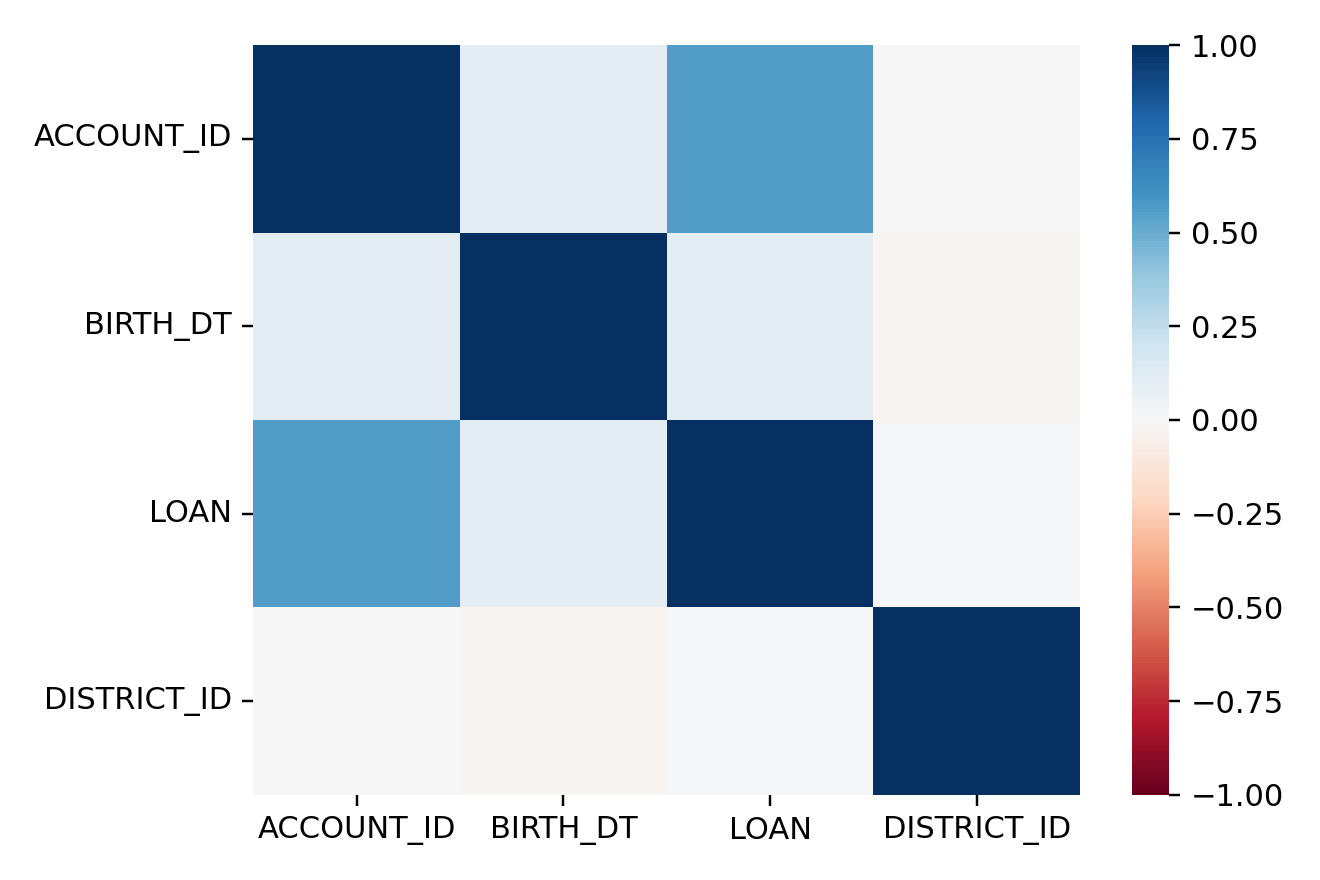

In [16]:
figure(figsize=(6, 4))
sns.heatmap(customers_clean.corr(), cmap="RdBu", vmin=-1, vmax=1)
tight_layout()

Curiously, the account ID seems to be the strongest predictor of the loan variable. That was unexpected.

## Districts table

### Missing values

In [17]:
print(districts.shape)
print(districts.dropna().shape)

(77, 10)
(77, 10)


There are no numerical values missing in this dataset. Now to look for data types and possible bad values in strings etc. 

In [18]:
districts.dtypes

DISTRICT_ID      int64
N_INHAB          int64
N_CITIES         int64
URBAN_RATIO    float64
AVG_SALARY       int64
UNEMP_95        object
UNEMP_96       float64
N_ENTR           int64
CRIME_95        object
CRIME_96         int64
dtype: object

The column `UNEMP_95` looks like it should be a `float64`, and `CRIME_95` looks like it should be an `int64`.

In [19]:
districts[["CRIME_95", "CRIME_96", "UNEMP_95", "UNEMP_96"]].head()

,CRIME_95,CRIME_96,UNEMP_95,UNEMP_96
0,85677,99107,0.29,0.43
1,2159,2674,1.67,1.85
2,2824,2813,1.95,2.21
3,5244,5892,4.64,5.05
4,2616,3040,3.85,4.43


As suspected, they are just string versions of the correct data types. Now to correct them, I first tried to simply change the data type, but there are missing values represented by a `?`, so instead I need to do this:

In [20]:
districts.UNEMP_95 = districts.UNEMP_95.map(lambda x: np.nan if x=="?" else np.float64(x))
districts.CRIME_95 = districts.CRIME_95.map(lambda x: np.nan if x=="?" else np.int64(x))
districts.dtypes

DISTRICT_ID      int64
N_INHAB          int64
N_CITIES         int64
URBAN_RATIO    float64
AVG_SALARY       int64
UNEMP_95       float64
UNEMP_96       float64
N_ENTR           int64
CRIME_95       float64
CRIME_96         int64
dtype: object

### Crime rates instead of counts

When districts have different sizes, raw counts of e.g. crime are not very useful; we want the per-capita ratio instead. Also, since the `DISTRICT_ID` column is important, we check that all values here are unique.

In [21]:
districts["CRIMERATE_95"] = districts["CRIME_95"] / districts["N_INHAB"]
districts["CRIMERATE_96"] = districts["CRIME_96"] / districts["N_INHAB"]
print(districts.DISTRICT_ID.shape, districts.DISTRICT_ID.unique().shape)
districts_clean = districts.drop(["CRIME_95", "CRIME_96"], axis=1)
districts_clean.head()

(77,) (77,)


,DISTRICT_ID,N_INHAB,N_CITIES,URBAN_RATIO,AVG_SALARY,UNEMP_95,UNEMP_96,N_ENTR,CRIMERATE_95,CRIMERATE_96
0,1,1204953,1,100.0,12541,0.29,0.43,167,0.071104,0.082250
1,2,88884,5,46.7,8507,1.67,1.85,132,0.024290,0.030084
2,3,75232,5,41.7,8980,1.95,2.21,111,0.037537,0.037391
3,4,149893,6,67.4,9753,4.64,5.05,109,0.034985,0.039308
4,5,95616,6,51.4,9307,3.85,4.43,118,0.027359,0.031794


All looks good now, the `DISTRICT_ID` column is unique and all data types look like they make sense.

In [22]:
districts_clean.dtypes

DISTRICT_ID       int64
N_INHAB           int64
N_CITIES          int64
URBAN_RATIO     float64
AVG_SALARY        int64
UNEMP_95        float64
UNEMP_96        float64
N_ENTR            int64
CRIMERATE_95    float64
CRIMERATE_96    float64
dtype: object

### Correlation heat map


<IPython.core.display.Javascript object>


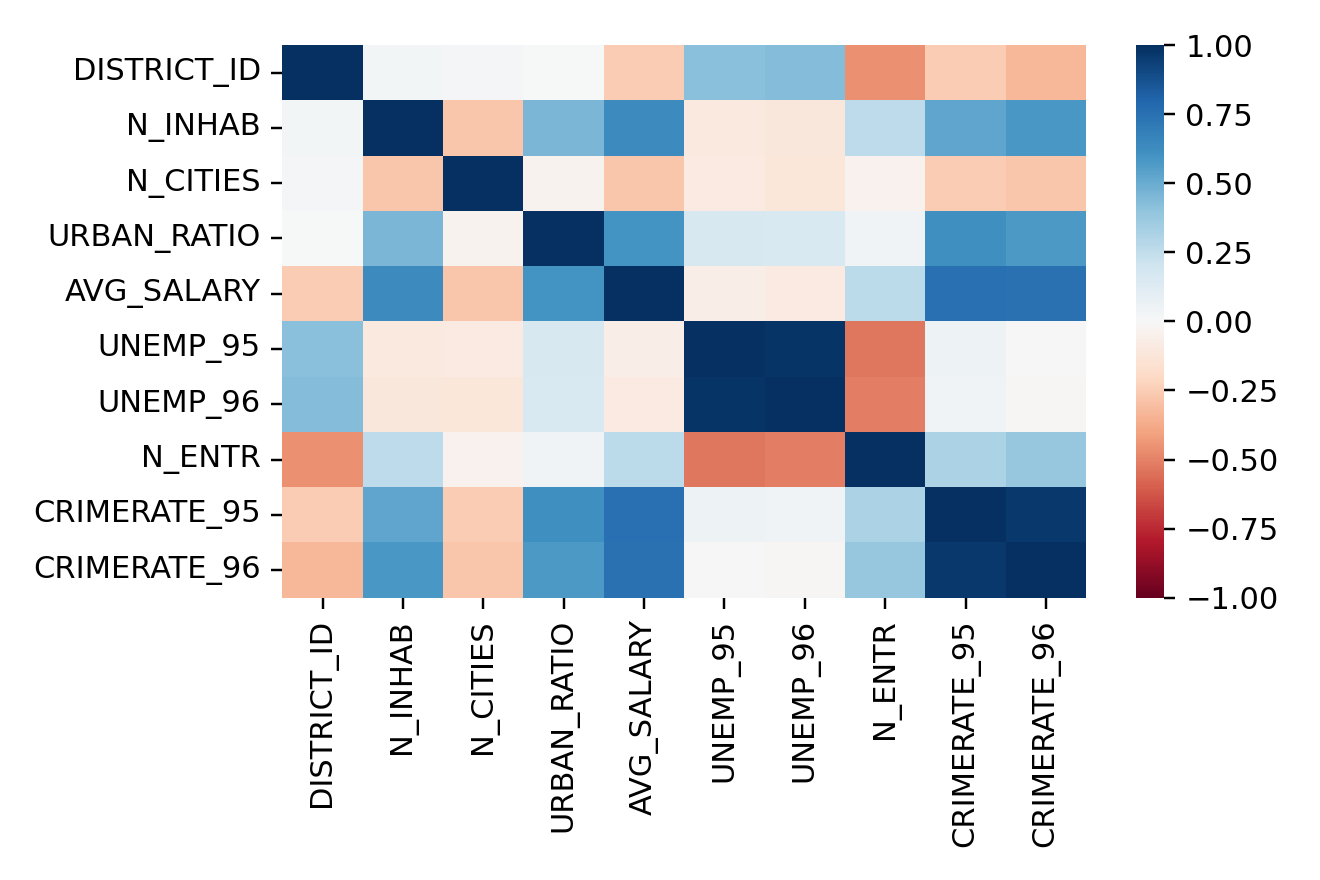

In [30]:
figure(figsize=(6, 4))
sns.heatmap(districts_clean.corr(), cmap="RdBu", vmin=-1, vmax=1)
tight_layout()

## Transactions table

### Missing values

In [24]:
print(transacts.shape)
print(transacts.dropna().shape)

(1066320, 7)
(877295, 7)


A large number of transactions have missing values. Now to figure out if these transactions should be removed or not.

In [25]:
null_cols = set(where(transacts.isnull())[1])
print([transacts.columns[k] for k in null_cols])

['ACCOUNT_ID', 'OPERATION']


The `OPERATION` column is somewhat redundant with the `TYPE` column, so transactions without this value can be kept for now. The `ACCOUNT_ID` is on the other hand so important that transactions without it are worthless, so we remove those.


In [26]:
transacts_nonan = transacts.dropna(subset=["ACCOUNT_ID"])
transacts_nonan.shape, transacts.shape

((1061320, 7), (1066320, 7))

### Check data types

First, to check that data types of the different columns look good. Also, check that the values of categorical variables make sense.


In [27]:
print(transacts_nonan.TYPE.value_counts(), "\n")
print(transacts_nonan.OPERATION.value_counts(), "\n")
print(transacts_nonan.dtypes)

WITHDRAWAL    654334
CREDIT        406986
Name: TYPE, dtype: int64 

WITHDRAWAL_IN_CASH            436957
REMITTANCE_TO_OTHER_BANK      209291
CREDIT_IN_CASH                157493
COLLECTION_FROM_OTHER_BANK     65468
CC_WITHDRAWAL                   8086
Name: OPERATION, dtype: int64 

TRANS_ID        int64
ACCOUNT_ID    float64
DATE            int64
AMOUNT        float64
BALANCE       float64
TYPE           object
OPERATION      object
dtype: object


`ACCOUNT_ID` should be an integer, but otherwise it looks good.

In [28]:
transacts_nonan.ACCOUNT_ID = transacts_nonan.ACCOUNT_ID.astype(np.int64)
transacts_clean = transacts_nonan
transacts_clean.head()

/home/trive/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,TRANS_ID,ACCOUNT_ID,DATE,AMOUNT,BALANCE,TYPE,OPERATION
0,695247,2378,1011993,700.0,700.0,CREDIT,CREDIT_IN_CASH
1,171812,576,1011993,900.0,900.0,CREDIT,CREDIT_IN_CASH
2,207264,704,1011993,1000.0,1000.0,CREDIT,CREDIT_IN_CASH
3,1117247,3818,1011993,600.0,600.0,CREDIT,CREDIT_IN_CASH
4,579373,1972,2011993,400.0,400.0,CREDIT,CREDIT_IN_CASH


### Correlation heat map

<IPython.core.display.Javascript object>


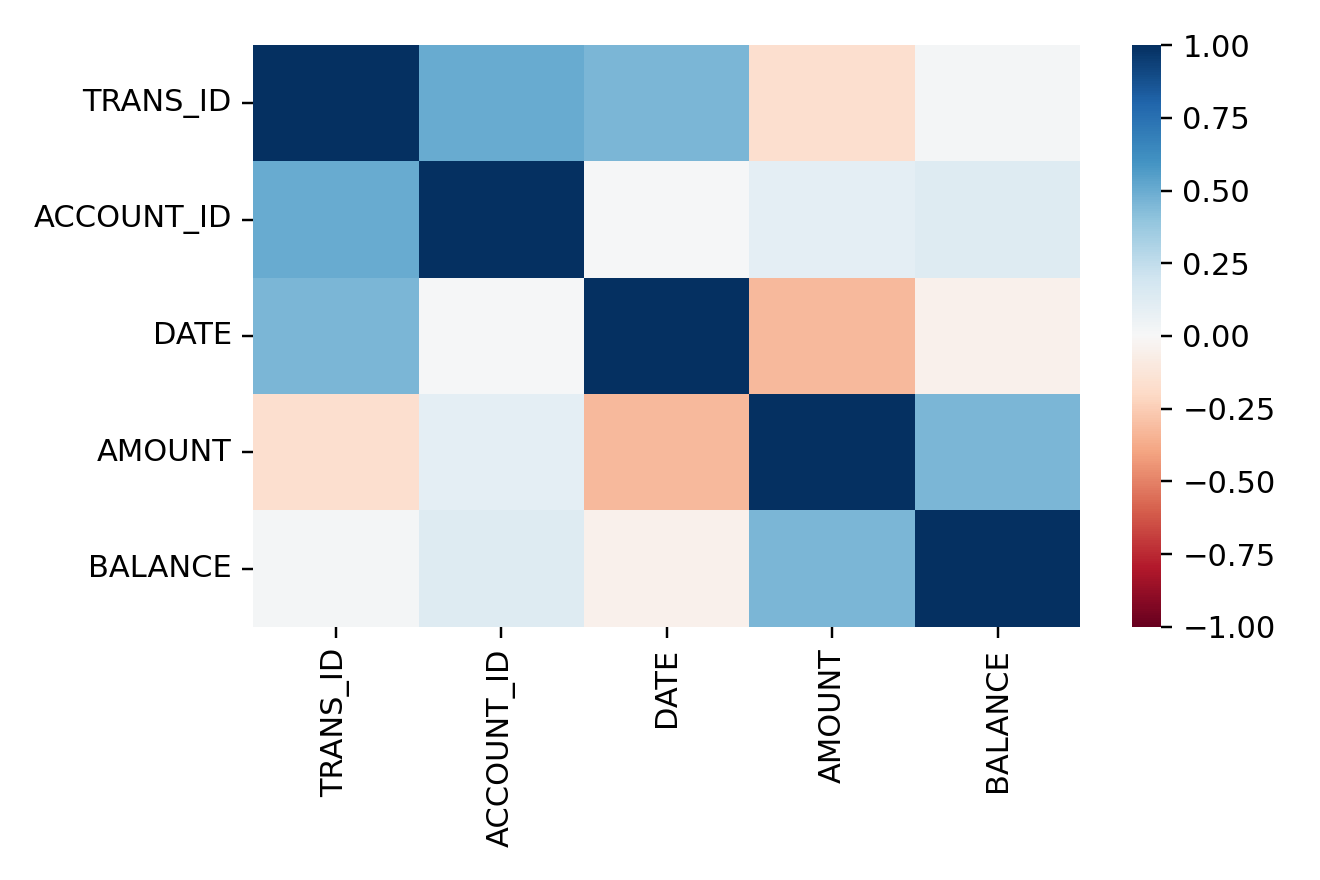

In [32]:
figure(figsize=(6, 4))
sns.heatmap(transacts_clean.corr(), cmap="RdBu", vmin=-1, vmax=1)
tight_layout()

# Data analysis

## Join tables

We want to join tables to see whether e.g. geographic factors could have an impact on the probability of getting a loan, or on people's financial transaction habits. If I had more time, I might join information from all three tables into one, but that would require some deliberation, so will not to that now. 

Now I only join them pairwise as proof of concept.

### Transactions and Customers

In [33]:
customers_transacts = customers_clean.set_index(
    "ACCOUNT_ID").join(
    transacts_clean.set_index("ACCOUNT_ID")).reset_index()
print(customers_transacts.shape)
customers_transacts.head()

(1036735, 12)


,ACCOUNT_ID,GENDER,BIRTH_DT,LOAN,DISTRICT_ID,SET_SPLIT,TRANS_ID,DATE,AMOUNT,BALANCE,TYPE,OPERATION
0,1,F,19701213,0,18,TRAIN,1,24031995,1000.0,1000.0,CREDIT,CREDIT_IN_CASH
1,1,F,19701213,0,18,TRAIN,5,13041995,3679.0,4679.0,CREDIT,COLLECTION_FROM_OTHER_BANK
2,1,F,19701213,0,18,TRAIN,199,23041995,12600.0,17279.0,CREDIT,CREDIT_IN_CASH
3,1,F,19701213,0,18,TRAIN,3530438,30041995,19.2,17298.2,CREDIT,NaN
4,1,F,19701213,0,18,TRAIN,6,13051995,3679.0,20977.2,CREDIT,COLLECTION_FROM_OTHER_BANK


### Customers-Transactions correlations

A heat map of the correlation matrix is a good way to see if any data columns are redundant due to strong correlation.

<IPython.core.display.Javascript object>


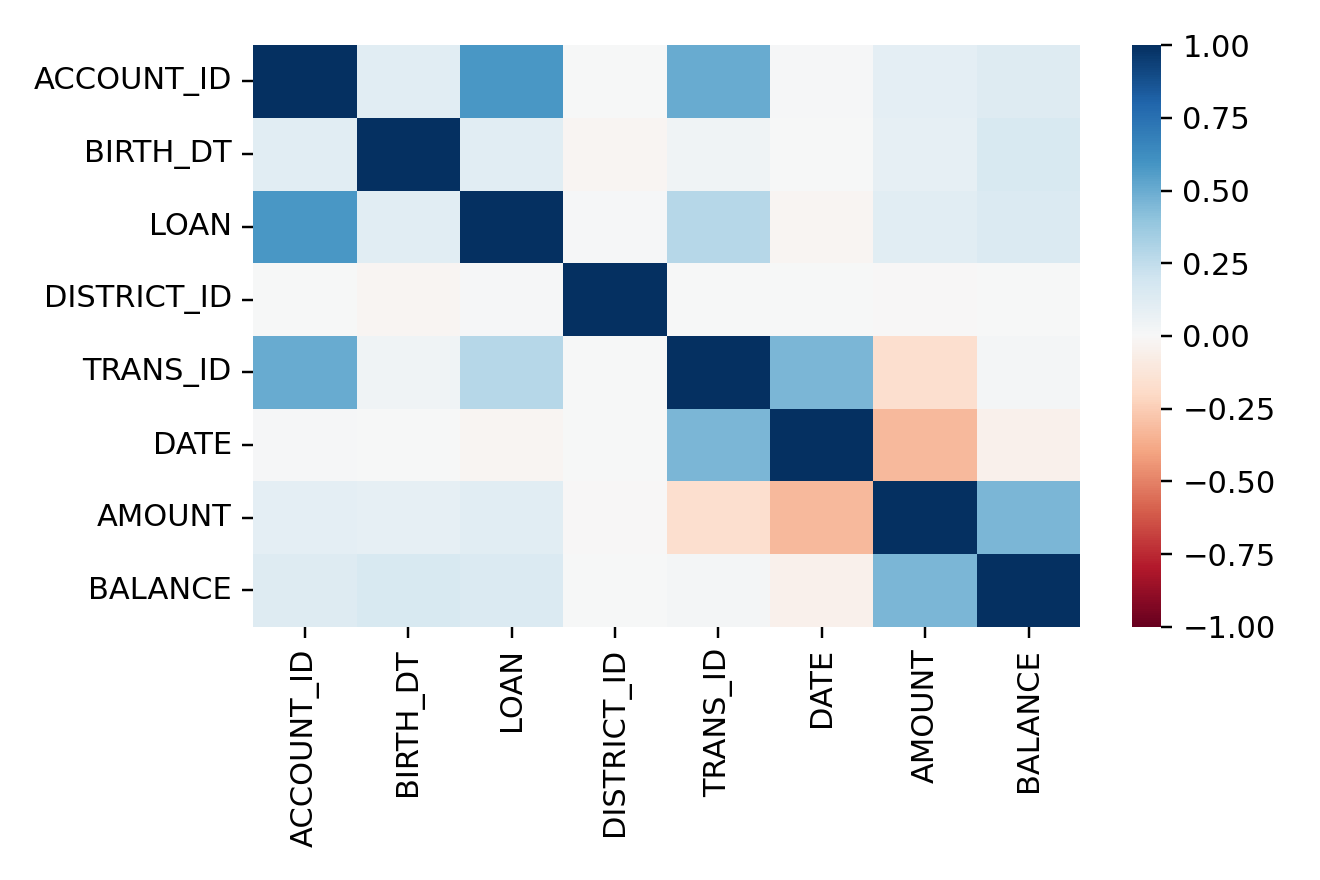

In [34]:
figure(figsize=(6, 4))
sns.heatmap(customers_transacts.corr(), cmap="RdBu", vmin=-1, vmax=1)
tight_layout()

### Join Customers and districts

In [36]:
customers_districts = customers_clean.set_index(
    "DISTRICT_ID").join(
    districts_clean.set_index("DISTRICT_ID")).reset_index()
customers_districts.head()

,DISTRICT_ID,ACCOUNT_ID,GENDER,BIRTH_DT,LOAN,SET_SPLIT,N_INHAB,N_CITIES,URBAN_RATIO,AVG_SALARY,UNEMP_95,UNEMP_96,N_ENTR,CRIMERATE_95,CRIMERATE_96
0,1,2,M,19450204,1,TRAIN,1204953,1,100.0,12541,0.29,0.43,167,0.071104,0.08225
1,1,17,F,19691011,0,TRAIN,1204953,1,100.0,12541,0.29,0.43,167,0.071104,0.08225
2,1,22,M,19450929,0,TRAIN,1204953,1,100.0,12541,0.29,0.43,167,0.071104,0.08225
3,1,49,F,19270429,0,TRAIN,1204953,1,100.0,12541,0.29,0.43,167,0.071104,0.08225
4,1,50,M,19570218,0,TEST,1204953,1,100.0,12541,0.29,0.43,167,0.071104,0.08225


### Customers/Districts correlattion plot

<IPython.core.display.Javascript object>


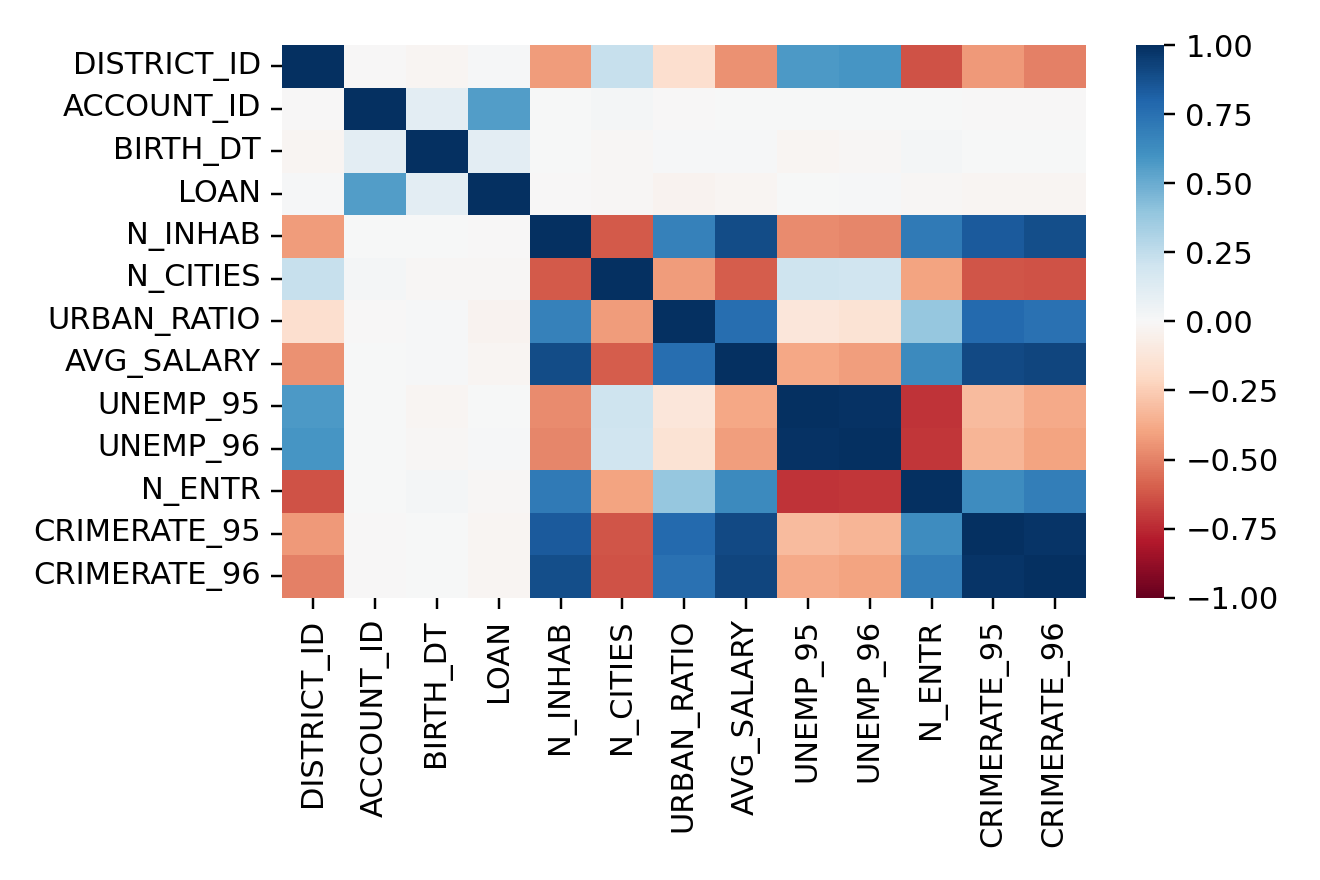

In [60]:
figure(figsize=(6, 4))
sns.heatmap(customers_districts.corr(),  cmap="RdBu", vmin=-1, vmax=1)
tight_layout()

### Quicklook: How do customer age, average salary and urban ration affect loan probability?

<IPython.core.display.Javascript object>


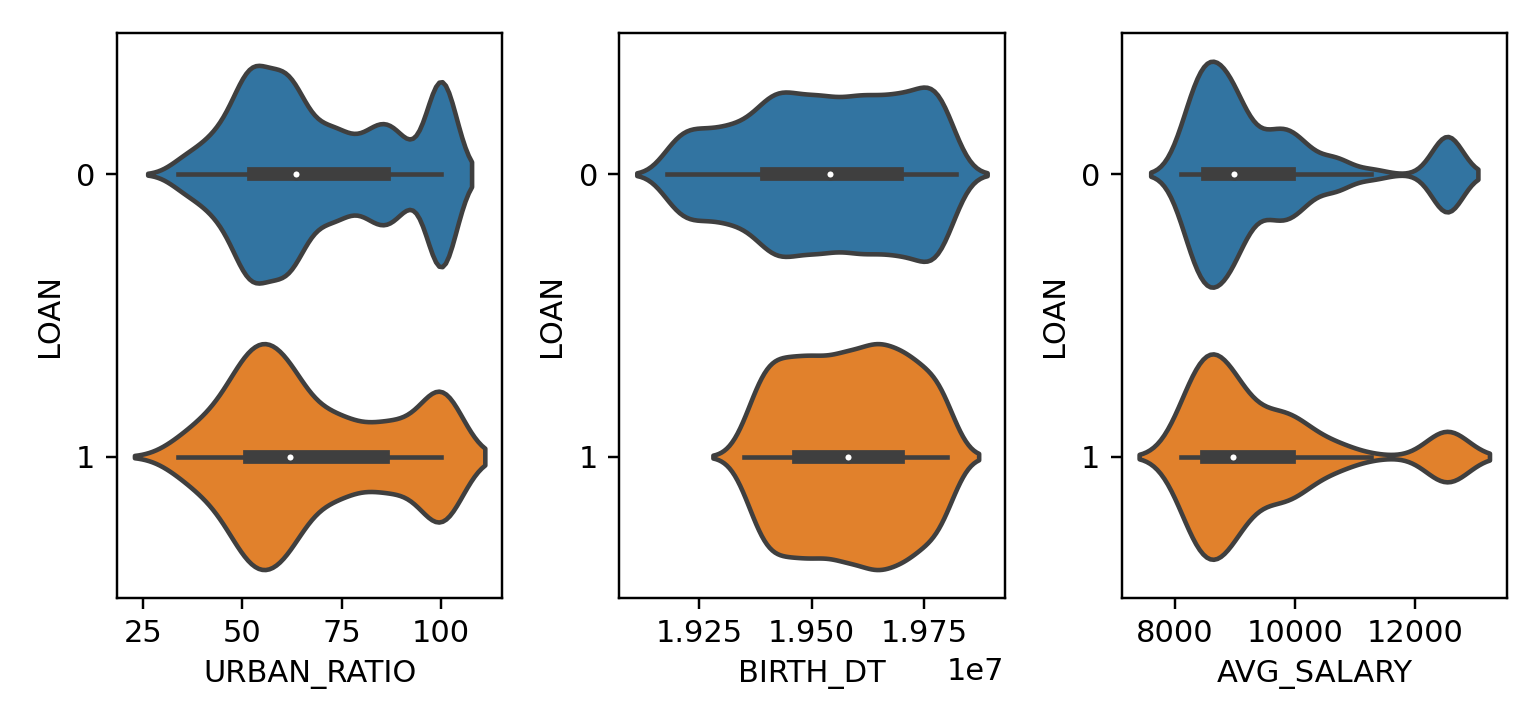

In [58]:
fig, axes = plt.subplots(1, 3, figsize=(7, 3.3))
sns.violinplot(
    data=customers_districts, x="URBAN_RATIO", y="LOAN", 
    ax=axes[0], orient="horizontal")
sns.violinplot(
    data=customers_districts, x="BIRTH_DT", y="LOAN", 
    ax=axes[1], orient="horizontal")
sns.violinplot(
    data=customers_districts, x="AVG_SALARY", y="LOAN", 
    ax=axes[2], orient="horizontal")
tight_layout()

There are surprisingly small correlations between these factor and whether people get loans. The strongest effect is in birth date, still very weak, and mainly says that people don't get loans below a certain age.

## Quicklook: Average number of transactions per customer

In [45]:
transacts_per_cust = customers_transacts.groupby(
    ["ACCOUNT_ID", "DISTRICT_ID", "GENDER"]).count()["AMOUNT"]
transacts_per_cust.head()

ACCOUNT_ID  DISTRICT_ID  GENDER
1           18           F         240
2           1            M         482
3           5            M         117
5           15           M          86
6           51           F         246
Name: AMOUNT, dtype: int64

In [51]:
mtpc = transacts_per_cust.mean()
print(f"Mean # of transactions per customer: {mtpc}")

Mean # of transactions per customer: 235.6215909090909


<IPython.core.display.Javascript object>


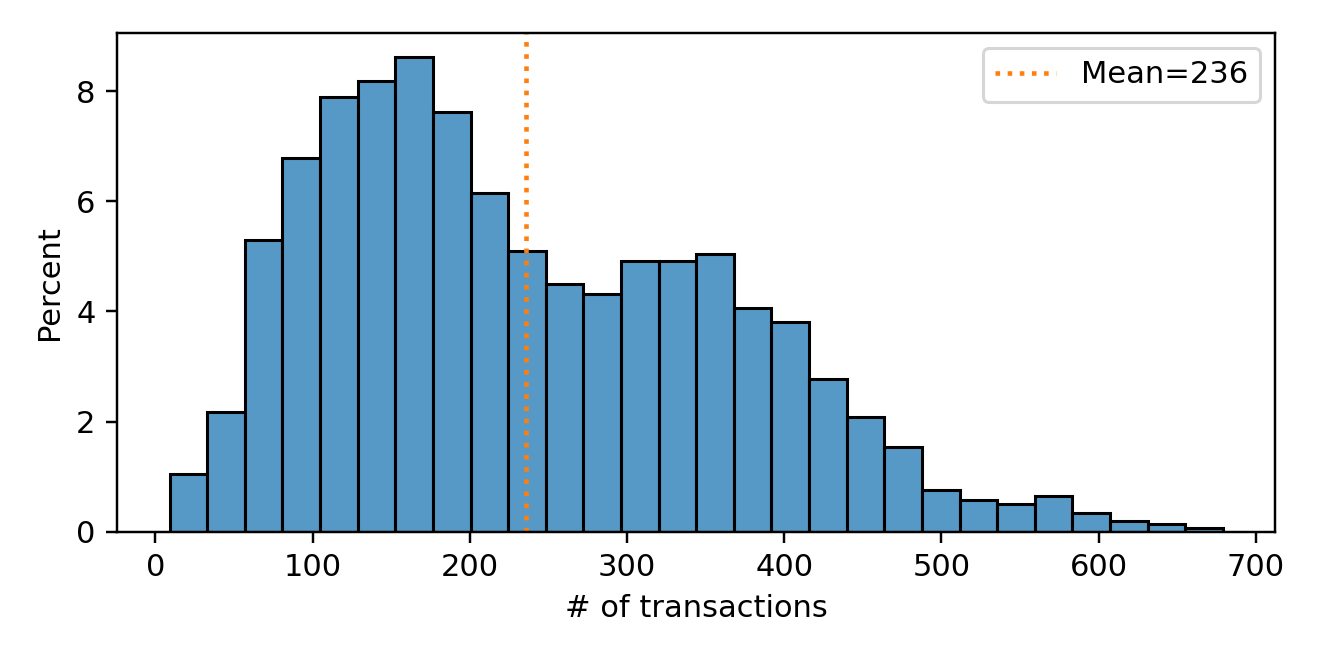

In [55]:
figure(figsize=(6, 3))
transact_count = transacts_clean.groupby("ACCOUNT_ID").count()["AMOUNT"]
sns.histplot(transact_count, stat="percent")
axvline(mtpc, color="C1", ls=":", label=f"Mean={mtpc:.0f}")
legend()
xlabel("# of transactions")
tight_layout()

## Quiclook: Average amount per transaction

By gender and geographical district.

In [65]:
amount_per_cust = customers_transacts.groupby(
    ["ACCOUNT_ID", "DISTRICT_ID", "GENDER"]).mean()["AMOUNT"].reset_index()
apc_by_district = amount_per_cust.groupby("DISTRICT_ID").mean()["AMOUNT"]
apc_by_gender = amount_per_cust.groupby("GENDER").mean()["AMOUNT"]
apc_by_gender

GENDER
F    5622.576709
M    5860.258691
Name: AMOUNT, dtype: float64

<IPython.core.display.Javascript object>


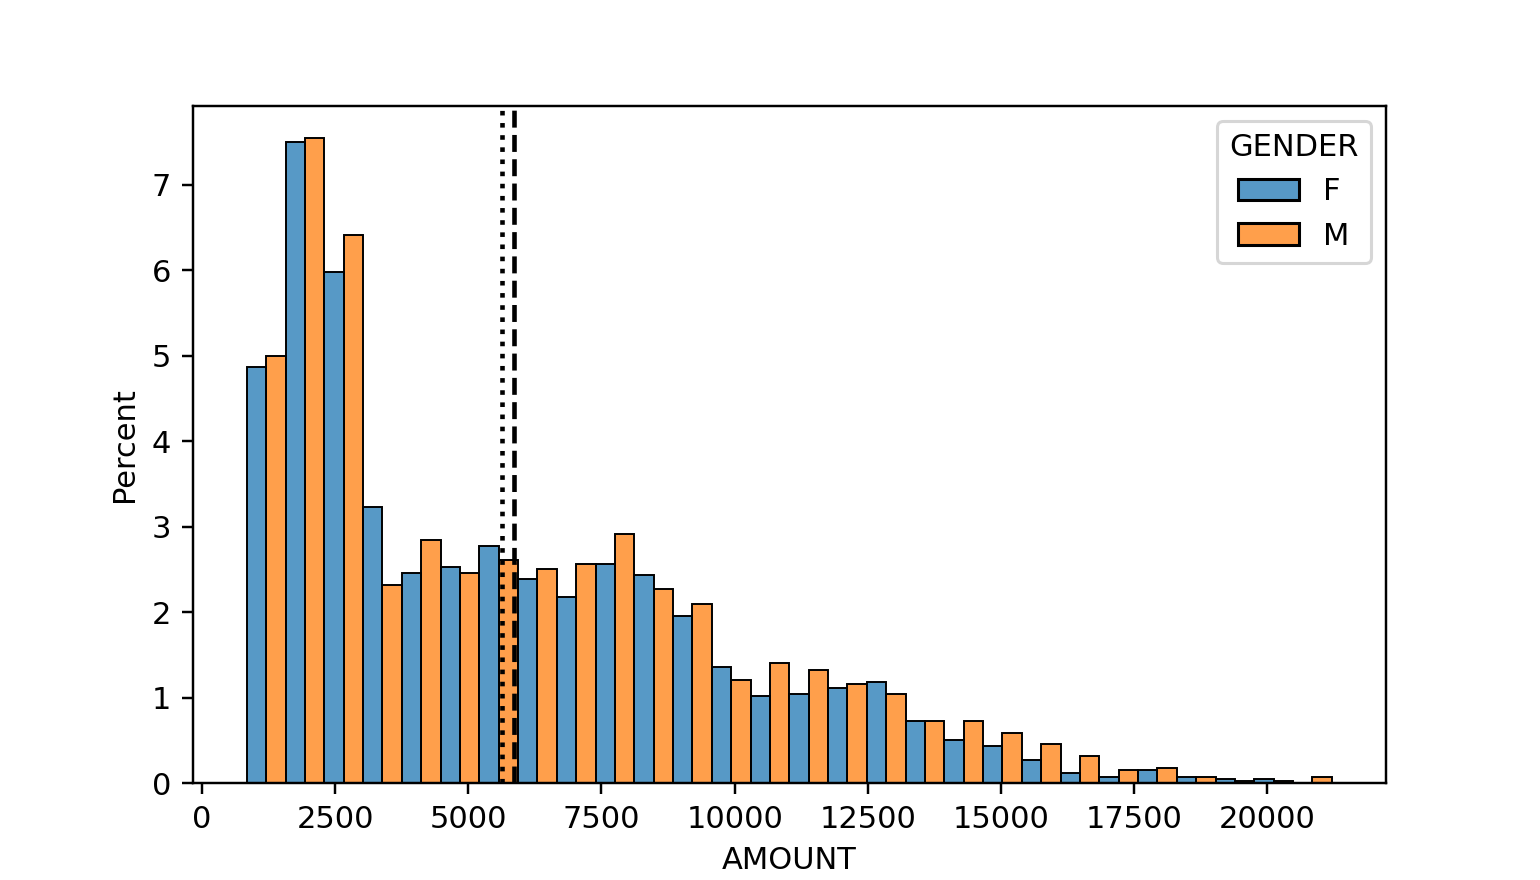

In [76]:
figure(figsize=(7, 4))
avg_spend = customers_transacts.groupby(
    ["ACCOUNT_ID", "GENDER"]).mean().reset_index(level=1)
sns.histplot(avg_spend, x="AMOUNT", stat="percent", hue="GENDER", multiple="dodge")
axvline(
    avg_spend.set_index("GENDER").loc["M"]["AMOUNT"].mean(),  #.values, 
    ls="--", color="k")
axvline(
    avg_spend.set_index("GENDER").loc["F"]["AMOUNT"].mean(),  #.values, 
    ls=":", color="k")

In [70]:
avg_spend.set_index("GENDER")

,BIRTH_DT,LOAN,DISTRICT_ID,TRANS_ID,DATE,AMOUNT,BALANCE
GENDER,,,,,,,
F,19701213.0,0.0,18.0,6.620574e+05,1.892045e+07,1568.102083,15979.748333
M,19450204.0,1.0,1.0,5.058519e+05,1.772341e+07,6565.653734,36522.167842
M,19561201.0,0.0,5.0,5.439443e+05,1.532721e+07,2499.583761,27046.064957
M,19290125.0,0.0,15.0,6.579083e+05,2.034118e+07,1941.930233,25103.881395
F,19380221.0,0.0,51.0,6.757552e+05,1.977992e+07,2644.684959,34549.831301
...,...,...,...,...,...,...,...
M,19420101.0,0.0,8.0,3.439924e+06,2.254151e+07,9000.176087,46290.485870
F,19451030.0,1.0,1.0,3.435803e+06,1.728335e+07,13013.252961,48778.241776
M,19680413.0,1.0,61.0,3.437591e+06,1.772312e+07,7795.143864,36012.716710
